#### Imports 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import Aer
from math import pi,log
from qiskit import *
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
import numpy as np
# from qiskit import IBMQ
import os
from datetime import datetime
from qiskit.circuit.library import UnitaryGate
import scipy
from scipy.stats import entropy
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Running and Saving Details

In [46]:
from datetime import datetime
# Network saving and loading
epoch = 25
runtime_name = datetime.now().strftime("Date-%d%m%y--Hours-%H%M")
runtime_name += "-epoch-{}".format(epoch)
os.mkdir(runtime_name)
backend = Aer.get_backend('qasm_simulator')

#### Get Data

In [47]:
# Subsample to SUBSAMPLE datapoints. This is due to computational cost.
# Chance SUBSAMPLE to what best suits your computer, to make a reasonable training time.
test_images,test_labels = tf.keras.datasets.mnist.load_data()
train_images = test_images[0].reshape(60000,784)
train_labels = test_images[1]
labels = test_images[1]
train_images = train_images/255
k=4
pca = PCA(n_components=k)
pca.fit(train_images)

# Computational cost is high for 60,000 data points. Change 6000 to what your system can handle
SUBSAMPLE = 1000
pca_data = pca.transform(train_images)[:SUBSAMPLE]
train_labels = train_labels[:SUBSAMPLE]
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

### <font color='green'> Data Transformation

<font color='green'> Changes made: no rotations or squaring before filtering out unused data.

In [48]:
# Data Transformation Section
for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()
pca_data_rot= 2*np.arcsin(np.sqrt(pca_data))
valid_labels = None
valid_labels = train_labels==3
valid_labels += train_labels == 6

for col in range(pca_data.shape[1]):
    t_data_mean = pca_data[:,col].mean()
    t_data_std = pca_data[:,col].std()
    valid_upper_bound = pca_data[:,col] < t_data_mean+t_data_std
    valid_lower_bound = pca_data[:,col] > t_data_mean-t_data_std
    valid = np.logical_and(valid_upper_bound,valid_lower_bound)
    pca_data = pca_data[valid]
pca_data_rot3 = pca_data_rot[train_labels==3]
pca_data_rot6 = pca_data_rot[train_labels==6]

#### Utils

In [49]:
# Checkpointing code
def save_variables(var_dict, epoch, number_class):
    with open(f"{runtime_name}/Epoch-{epoch}-Variables-numbers-{number_class}", 'w') as file:
        file.write(str(var_dict))

# Ran_ang returns a random angle
def ran_ang():
    return np.random.rand() * 2 * np.pi


def single_qubit_unitary(circ_ident, qubit_index, values):
    circ_ident.ry(values[0], qubit_index)
    circ_ident.rz(values[1], qubit_index)


def dual_qubit_unitary(circ_ident, qubit_1, qubit_2, values):
    circ_ident.ryy(values[0], qubit_1, qubit_2)
    circ_ident.rzz(values[1], qubit_1, qubit_2)


def controlled_dual_qubit_unitary(circ_ident, control_qubit, act_qubit, values):
    circ_ident.cry(values[0], control_qubit, act_qubit)
    circ_ident.crz(values[1], control_qubit, act_qubit)


def traditional_learning_layer(circ_ident, num_qubits, values, style="Dual", qubit_start=1, qubit_end=5):
    if style == "Dual":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "," + str(qub + 1)])
    elif style == "Single":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
    elif style == "Controlled-Dual":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "," + str(qub + 1)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            controlled_dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "--" + str(qub + 1)])


def swap_test(circ_ident, num_qubits):
    num_swap = num_qubits // 2
    for i in range(num_swap):
        circ_ident.cswap(0, i + 1, i + num_swap + 1)
    circ_ident.h(0)
    circ_ident.measure(0, 0)


def init_random_variables(q, style):
    trainable_variables = {}
    if style == "Single":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
    elif style == "Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [ran_ang(), ran_ang()]
    elif style == "Controlled-Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [ran_ang(), ran_ang()]
                trainable_variables[str(i) + "--" + str(i + 1)] = [ran_ang(), ran_ang()]
    return trainable_variables


def init_gradient_variables(q, style):
    trainable_variables = {}
    if style == "Single":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [[], []]
    elif style == "Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [[], []]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [[], []]
    elif style == "Controlled-Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [0, 0]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [[], []]
                trainable_variables[str(i) + "--" + str(i + 1)] = [[], []]
    return trainable_variables


def get_probabilities(circ, count=10000, inducing=False):
    if inducing == True:
        count *= 10
    qobj = assemble(circ, shots=count)
    job = backend.run(qobj)
    results = job.result().get_counts()
    #job = execute(circ, backend, shots=count)
    #results = job.result().get_counts(circ)    
    try:
        prob = results['0'] / (results['1'] + results['0'])
        prob = (prob - 0.5)
        if prob <= 0:
            prob = 1e-16
        else:
            prob = prob * 2
    except:
        prob = 1
    return prob

# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p, yreal):
    if yreal == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)


def update_weights(init_value, lr, grad):
    while lr * grad > 2 * np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr * grad
    new_value = init_value
    if new_value - weight_update > 2 * np.pi:
        new_value = (new_value - weight_update) - 2 * np.pi
    elif new_value - weight_update < 0:
        new_value = (new_value - weight_update) + 2 * np.pi
    else:
        new_value = new_value - weight_update
    return new_value

### <font color='green'> Encode Data</font>

<font color='green'>Fully changed</font>

In [50]:
def data_loading_circuit(circ_ident, num_qubits, values, qubit_start=1, qubit_end=5):
    k = 0
    for qub in np.arange(qubit_start, qubit_end):
        circ_ident.ry(values[k], qub)
        try:
            circ_ident.rz(values[k + 1], qub)
        except:
            circ_ident.rz(0, qub)
        k += 2

#### Discriminator Training Circuit

In [51]:
# ------------------------------------------------------------------------------------
# We treat the first n qubits are the discriminators state. n is always defined as the
# integer division floor of the qubit count.
# This is due to the fact that a state will always be k qubits, therefore the
# number of total qubits must be 2k+1. 2k as we need k for the disc, and k to represent
# either the other learned quantum state, or k to represent a data point
# then +1 to perform the SWAP test. Therefore, we know that we will always end up
# with an odd number of qubits. We take the floor to solve for k. 1st k represents
# disc, 2nd k represents the "loaded" state be it gen or real data
# ------------------------------------------------------------------------------------
# Use different function calls to represent training a GENERATOR or training a DISCRIMINATOR
# ------------------------------------------------------------------------------------
def disc_real_training_circuit(training_variables, data, key=None, key_value=None, diff=False, fwd_diff=False):
    circ = QuantumCircuit(q, c)
    circ.h(0)
    if diff == True and fwd_diff == True:
        training_variables[key][key_value] += par_shift
    if diff == True and fwd_diff == False:
        training_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ, q, training_variables, style=layer_style, qubit_start=1, qubit_end=q // 2 + 1)
    data_loading_circuit(circ, q, data, qubit_start=q // 2 + 1, qubit_end=q)  
    swap_test(circ, q)
    if diff == True and fwd_diff == True:
        training_variables[key][key_value] -= par_shift
    if diff == True and fwd_diff == False:
        training_variables[key][key_value] += par_shift
    return circ

#### Procedure

Starting Training
--------------------
train_var_0 training
Time for Epoch 1 is 13.454985857009888 sec
Entropy: 0.7244840957232995
Loss 6.360644715726557
Accuracy 0.8235294117647058
--------------------
Time for Epoch 2 is 13.45996379852295 sec
Entropy: 0.7177386228567492
Loss 5.975151096591613
Accuracy 0.8342245989304813
--------------------
Time for Epoch 3 is 13.616475105285645 sec
Entropy: 0.7169515314411634
Loss 5.975151096591613
Accuracy 0.8342245989304813
--------------------
Time for Epoch 4 is 14.792648077011108 sec
Entropy: 0.7133206629768263
Loss 6.553391525294027
Accuracy 0.8181818181818182
--------------------
Time for Epoch 5 is 15.563379049301147 sec
Entropy: 0.711261552022699
Loss 6.360644715726557
Accuracy 0.8235294117647058
--------------------
Time for Epoch 1 is 16.013167142868042 sec
Entropy: 0.8419065736655398
Loss 2.1202149052421855
Accuracy 0.9411764705882353
--------------------
Time for Epoch 2 is 15.283251285552979 sec
Entropy: 0.8706854720765372
Loss 1.73472

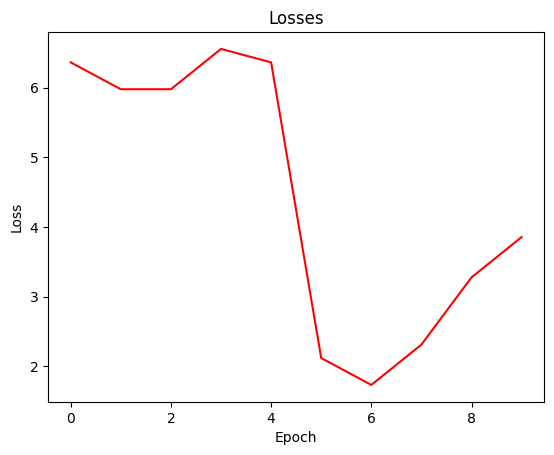

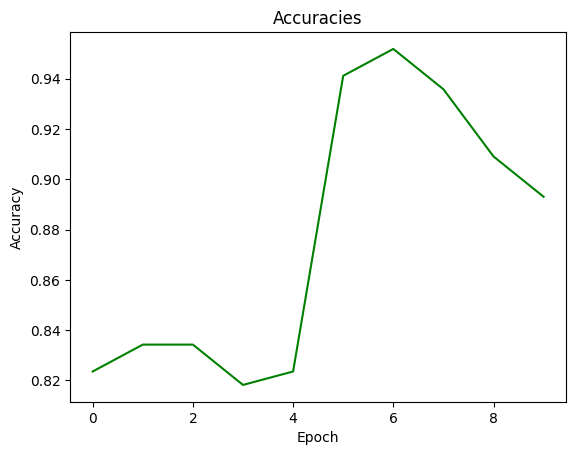

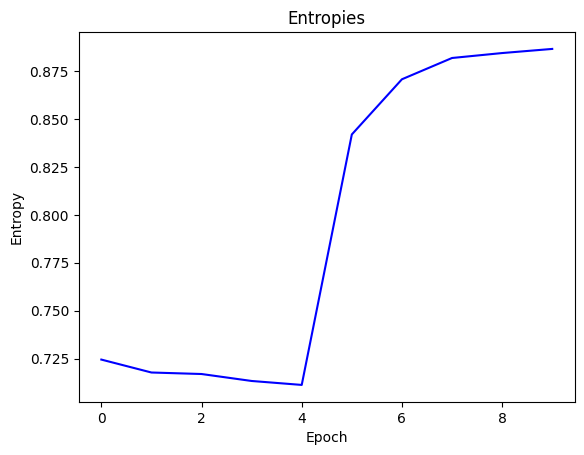

Ones predicted 114 Zeros predicted 73
Accuracy 0.893048128342246
Average entropy 0.8864133002760197


In [52]:
# ------------------------------------------------------------------------------------------
# THIS SECTION WE DO THE TUNING FOR WHAT WE KNOW WE WANT TO BE CHANGING!
# ------------------------------------------------------------------------------------------

q = 5  # Number of qubits = Dimensionality of data = round up to even number = num qubits
c = 1
circ = QuantumCircuit(q, c)
circ.h(0)
layer_style = "Dual"
train_var_0 = init_random_variables(q // 2, layer_style)
train_var_1 = init_random_variables(q // 2, layer_style)
train_var_2 = init_random_variables(q // 2, layer_style)

tracked_d_loss = []
tracked_d_loss1 = []
tracked_d_loss2 = []
gradients = []
learning_rate = 0.01
train_iter = 5
corr = 0
wrong = 0
loss_d_to_real = 0

losses = []
accuracies = []
entropies_all = []

print('Starting Training')
print('-' * 20)
print("train_var_0 training")
for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot3):
        for key, value in train_var_0.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_0[key][key_value] -= df * learning_rate

    # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_0, epoch, 3)

for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot6):
        for key, value in train_var_1.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_1[key][key_value] -= df * learning_rate

      # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_1, epoch, 6)

#CHANGE PCA_DATA_ROT VARS HERE
pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]

correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

for index, x in enumerate(pca_data):
    p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
    p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

plt.plot(losses, label='Losses', color='red')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies, label='Accuracies', color='green')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(entropies_all, label='Entropies', color='blue')
plt.title('Entropies')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.show()

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

Starting Training
--------------------
train_var_0 training
Time for Epoch 1 is 15.630874156951904 sec
Entropy: 0.8451439384704701
Loss 18.118200099342307
Accuracy 0.49732620320855614
--------------------
Time for Epoch 2 is 15.294928073883057 sec
Entropy: 0.8253882745576423
Loss 18.118200099342307
Accuracy 0.49732620320855614
--------------------
Time for Epoch 3 is 13.595793962478638 sec
Entropy: 0.8124656580822074
Loss 18.118200099342307
Accuracy 0.49732620320855614
--------------------
Time for Epoch 4 is 14.050097942352295 sec
Entropy: 0.8031041556812835
Loss 18.118200099342307
Accuracy 0.49732620320855614
--------------------
Time for Epoch 5 is 15.198230028152466 sec
Entropy: 0.7988388254360541
Loss 18.118200099342307
Accuracy 0.49732620320855614
--------------------
Time for Epoch 1 is 14.876241207122803 sec
Entropy: 0.9842392447993175
Loss 10.408327716643456
Accuracy 0.7112299465240641
--------------------
Time for Epoch 2 is 15.031358003616333 sec
Entropy: 0.9862570011028832


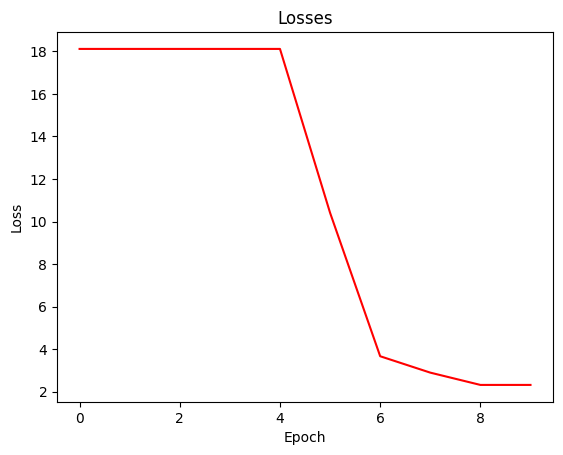

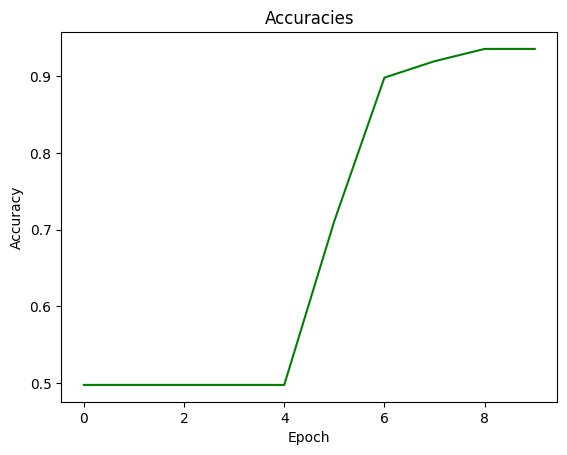

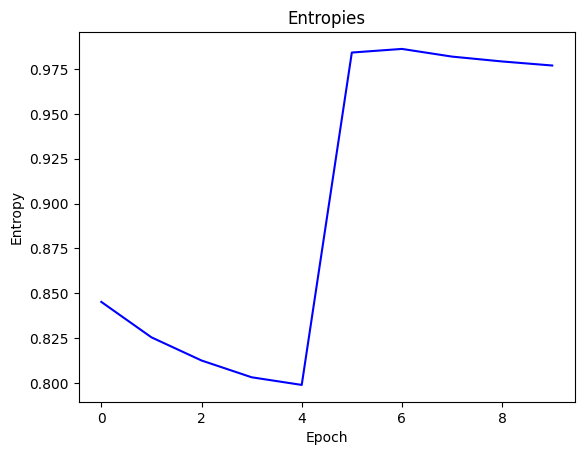

Ones predicted 105 Zeros predicted 82
Accuracy 0.93048128342246
Average entropy 0.9773120631843982


In [54]:
# ------------------------------------------------------------------------------------------
# THIS SECTION WE DO THE TUNING FOR WHAT WE KNOW WE WANT TO BE CHANGING!
# ------------------------------------------------------------------------------------------

q = 5  # Number of qubits = Dimensionality of data = round up to even number = num qubits
c = 1
circ = QuantumCircuit(q, c)
circ.h(0)
layer_style = "Dual"
train_var_0 = init_random_variables(q // 2, layer_style)
train_var_1 = init_random_variables(q // 2, layer_style)
train_var_2 = init_random_variables(q // 2, layer_style)

tracked_d_loss = []
tracked_d_loss1 = []
tracked_d_loss2 = []
gradients = []
learning_rate = 0.01
train_iter = 5
corr = 0
wrong = 0
loss_d_to_real = 0

losses = []
accuracies = []
entropies_all = []

print('Starting Training')
print('-' * 20)
print("train_var_0 training")
for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot3):
        for key, value in train_var_0.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_0[key][key_value] -= df * learning_rate

    # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_0, epoch, 3)

for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot6):
        for key, value in train_var_1.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_1[key][key_value] -= df * learning_rate

      # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_1, epoch, 6)

#CHANGE PCA_DATA_ROT VARS HERE
pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]

correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

for index, x in enumerate(pca_data):
    p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
    p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

plt.plot(losses, label='Losses', color='red')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies, label='Accuracies', color='green')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(entropies_all, label='Entropies', color='blue')
plt.title('Entropies')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.show()

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

Starting Training
--------------------
train_var_0 training
Time for Epoch 1 is 15.097222089767456 sec
Entropy: 0.8968518776193255
Loss 10.408327716643456
Accuracy 0.7112299465240641
--------------------
Time for Epoch 2 is 15.007639169692993 sec
Entropy: 0.8748383476045202
Loss 15.80523838453265
Accuracy 0.5614973262032086
--------------------
Time for Epoch 3 is 15.20593810081482 sec
Entropy: 0.8683502952396164
Loss 15.80523838453265
Accuracy 0.5614973262032086
--------------------
Time for Epoch 4 is 13.543605327606201 sec
Entropy: 0.8649984315423866
Loss 15.80523838453265
Accuracy 0.5614973262032086
--------------------
Time for Epoch 5 is 13.423774003982544 sec
Entropy: 0.8642965208538242
Loss 15.80523838453265
Accuracy 0.5614973262032086
--------------------
Time for Epoch 1 is 13.495913028717041 sec
Entropy: 0.8780478579028159
Loss 10.601074526210926
Accuracy 0.7058823529411765
--------------------
Time for Epoch 2 is 13.623251914978027 sec
Entropy: 0.8737513146875328
Loss 10.02

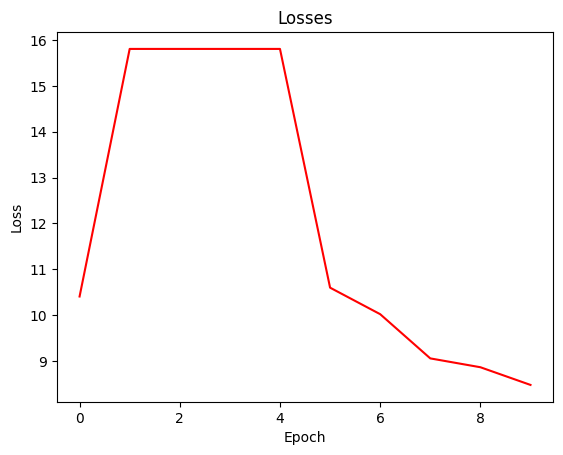

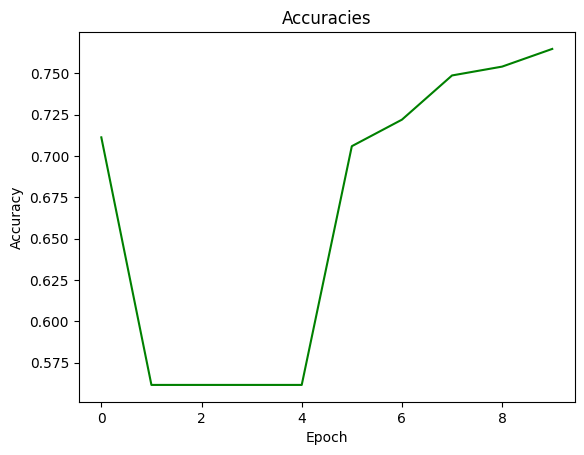

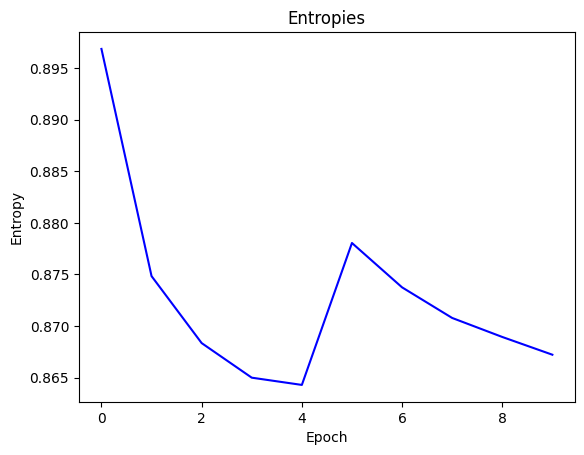

Ones predicted 48 Zeros predicted 139
Accuracy 0.7540106951871658
Average entropy 0.8683467669421671


In [55]:
# ------------------------------------------------------------------------------------------
# THIS SECTION WE DO THE TUNING FOR WHAT WE KNOW WE WANT TO BE CHANGING!
# ------------------------------------------------------------------------------------------

q = 5  # Number of qubits = Dimensionality of data = round up to even number = num qubits
c = 1
circ = QuantumCircuit(q, c)
circ.h(0)
layer_style = "Dual"
train_var_0 = init_random_variables(q // 2, layer_style)
train_var_1 = init_random_variables(q // 2, layer_style)
train_var_2 = init_random_variables(q // 2, layer_style)

tracked_d_loss = []
tracked_d_loss1 = []
tracked_d_loss2 = []
gradients = []
learning_rate = 0.01
train_iter = 5
corr = 0
wrong = 0
loss_d_to_real = 0

losses = []
accuracies = []
entropies_all = []

print('Starting Training')
print('-' * 20)
print("train_var_0 training")
for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot3):
        for key, value in train_var_0.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_0[key][key_value] -= df * learning_rate

    # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_0, epoch, 3)

for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot6):
        for key, value in train_var_1.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_1[key][key_value] -= df * learning_rate

      # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_1, epoch, 6)

#CHANGE PCA_DATA_ROT VARS HERE
pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]

correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

for index, x in enumerate(pca_data):
    p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
    p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

plt.plot(losses, label='Losses', color='red')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies, label='Accuracies', color='green')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(entropies_all, label='Entropies', color='blue')
plt.title('Entropies')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.show()

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

### Circuit Example